---
title: 3. Colocalizing In-Situ and Satellite Data
authors:
- gwenael_caer
- catherine_schmechtig
---

<hr>

<img src='https://gitlab.ifremer.fr/odatis/vre/tools/frameworks/-/raw/main/img/standard_banner.png' align='right' width='100%' style="margin-bottom: 1rem;"/>

<hr>

```{seealso} Learning outcomes
At the end of this notebook you will know;
* How to <font color="#2367a2">**colocalize**</font> in-situ and satellite data.
```

We begin by importing all of the libraries that we need to run this notebook. If you have built your python using the environment file provided in this repository, then you should have everything you need. For more information on building environment, please see the repository **<a href="../README.md" target="_blank">README</a>**.

In [ ]:
! pip install git+https://github.com/mercator-ocean/copernicus-marine-toolbox.git@aa3a6d2 --no-deps

In [1]:
import time
import copernicusmarine
import numpy as np
import pandas as pd
import pytcube
from tqdm import tqdm
import xarray as xr

/home1/datawork/gcaer/conda-env/odatis-bgc-argo/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from dask.distributed import Client

client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 8,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41277,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:45939,Total threads: 2
Dashboard: /proxy/39401/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:45453,


## 3.1 Load data

### In-situ data (BGC-Argo)

As seen in notebook #1, we will load the BGC-Argo profile index.

In [3]:
# Different ways of accessing the BGC-Argo index file
access = {
    'ftp': "ftp://ftp.ifremer.fr/ifremer/argo/argo_bio-profile_index.txt",
    'http': "https://data-argo.ifremer.fr/argo_bio-profile_index.txt",
    'local': "/home/ref-argo/gdac/argo_bio-profile_index.txt",
}

# Choose the access method that suits you best
path = access['http']

In [4]:
argo_bgc_index = "ftp://ftp.ifremer.fr/ifremer/argo/argo_bio-profile_index.txt"

df = pd.read_csv(argo_bgc_index, sep=",", header=8)
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d%H%M%S')
df = df[df['parameters'].str.contains('CHLA')].copy()
df['id'] = df['file'].str.split('/').str[1]
df = df.dropna(subset=['longitude', 'latitude', 'id', 'date'])
point = xr.Dataset.from_dataframe(df).rename({'index': 'obs', 'date': 'time'})
sub_point = point.isel(obs=slice(0, 1_000))
sub_point

<xarray.Dataset> Size: 96kB
Dimensions:              (obs: 1000)
Coordinates:
  * obs                  (obs) int64 8kB 1956 1957 1958 1959 ... 2958 2959 2960
Data variables:
    file                 (obs) object 8kB 'aoml/1902303/profiles/BD1902303_00...
    time                 (obs) datetime64[ns] 8kB 2021-05-06T02:03:16 ... 202...
    latitude             (obs) float64 8kB 49.24 49.1 48.91 ... 19.13 19.08
    longitude            (obs) float64 8kB -14.74 -14.62 -14.61 ... -31.86 -32.2
    ocean                (obs) object 8kB 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    profiler_type        (obs) int64 8kB 863 863 863 863 863 ... 863 863 863 863
    institution          (obs) object 8kB 'AO' 'AO' 'AO' 'AO' ... 'AO' 'AO' 'AO'
    parameters           (obs) object 8kB 'PRES TEMP_DOXY PHASE_DELAY_DOXY TE...
    parameter_data_mode  (obs) object 8kB 'RRRRDRAARARRRRRDRRD' ... 'RRRRDRAA...
    date_update          (obs) int64 8kB 20250625040143 ... 20250809000054
    id                   (obs) object 8kB '1902303' '1902303' ... '1902382'

### Satellite data (OCEANCOLOUR)

As seen in notebook #2, we will load the OCEANCOLOUR data.

In [5]:
# The different datasets required for this use case
dataset_ids = {
    'optics': 'cmems_obs-oc_glo_bgc-optics_my_l3-multi-4km_P1D',
    'plankton': 'cmems_obs-oc_glo_bgc-plankton_my_l3-multi-4km_P1D',
    'reflectance': 'cmems_obs-oc_glo_bgc-reflectance_my_l3-multi-4km_P1D',
    'transp': 'cmems_obs-oc_glo_bgc-transp_my_l3-multi-4km_P1D',
}

# Choose a service and a dataset name
service = 'timeseries' # or 'geoseries'
name = 'optics'
dataset_id = dataset_ids[name]

In [6]:
%%time
# Open a single dataset
grid = copernicusmarine.open_dataset(
    dataset_id = dataset_id,
    service = service, 
    chunk_size_limit = 1
)
grid

INFO - 2025-10-29T13:04:19Z - Selected dataset version: "202311"
INFO - 2025-10-29T13:04:19Z - Selected dataset part: "default"


CPU times: user 353 ms, sys: 209 ms, total: 562 ms
Wall time: 2.03 s


<xarray.Dataset> Size: 10TB
Dimensions:          (time: 10275, latitude: 4320, longitude: 8640)
Coordinates:
  * time             (time) datetime64[ns] 82kB 1997-09-04 ... 2025-10-21
  * latitude         (latitude) float32 17kB -89.98 -89.94 -89.9 ... 89.94 89.98
  * longitude        (longitude) float32 35kB -180.0 -179.9 ... 179.9 180.0
Data variables:
    BBP              (time, latitude, longitude) float32 2TB dask.array<chunksize=(1924, 16, 16), meta=np.ndarray>
    BBP_uncertainty  (time, latitude, longitude) float64 3TB dask.array<chunksize=(1924, 16, 16), meta=np.ndarray>
    CDM              (time, latitude, longitude) float32 2TB dask.array<chunksize=(1924, 16, 16), meta=np.ndarray>
    CDM_uncertainty  (time, latitude, longitude) float64 3TB dask.array<chunksize=(1924, 16, 16), meta=np.ndarray>
    flags            (time, latitude, longitude) int8 384GB dask.array<chunksize=(1924, 16, 16), meta=np.ndarray>
Attributes: (12/91)
    Conventions:                     CF-1.8, ACDD-1.3
    DPM_reference:                   GC-UD-ACRI-PUG
    IODD_reference:                  GC-UD-ACRI-PUG
    acknowledgement:                 The Licensees will ensure that original ...
    citation:                        The Licensees will ensure that original ...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L3_MY_009_103
    ...                              ...
    time_coverage_end:               2024-01-09T05:12:51Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2024-01-07T17:58:57Z
    title:                           cmems_obs-oc_glo_bgc-optics_my_l3-multi-...
    westernmost_longitude:           -180.0
    westernmost_valid_longitude:     -180.0

## 3.2 Colocation

In our use case, we aim to calibrate and validate the BGC-Argo data. To do this, we perform the **colocation** between **in-situ Argo observations** and the **Ocean Colour satellite grid** using PytCube’s `.colocation()` method.

Colocation enables us to **extract the portion of the satellite dataset surrounding each in-situ measurement**, according to a user-defined spatial and temporal search window.
This is particularly useful when combining satellite and in-situ data, as it allows us to retrieve the satellite context (e.g., nearby pixel values) for each Argo profile.

Before we proceed further, let’s define a few terms.

For the remainder of our use case, we will refer to:

* **point**: the BGC-Argo profile dataset, sourced from the BGC-Argo index.
* **grid**: the OCEANCOLOUR satellite product.
* **search_window**: the size in pixels that we wish to extract from our grid around the coordinates of our profiles.

To summarize, we can illustrate the colocalization process with the following diagram:

![colocalisation schema](./_static/colocalisation_schema.png)

Here, we use the Argo observation coordinates (`time`, `latitude`, `longitude`) and define a **search window** of 5 time steps, 2 latitude cells, and 2 longitude cells.

We also specify `cyclic_dims = ['longitude']`, which indicates that **longitude is a cyclic dimension** — meaning that the grid wraps around the globe (e.g., 180°E connects seamlessly to −180°W).
With this setting, if a mini-cube extends beyond the longitudinal edge of the grid, PytCube automatically takes the corresponding values from the opposite side, ensuring global spatial continuity.

The result, stored in `lazy_result`, is a **lazy xarray.Dataset**, meaning that the colocation computation is deferred until explicitly execute

In [7]:
%%time
lazy_result = grid.pytcube.colocation(
    obs = sub_point.obs,
    time = sub_point.time,
    latitude = sub_point.latitude,
    longitude = sub_point.longitude,
    search_window = {'time':5, 'latitude':2, 'longitude':2},
    cyclic_dims = ['longitude'],
)
lazy_result

CPU times: user 688 ms, sys: 66.1 ms, total: 754 ms
Wall time: 676 ms


<xarray.Dataset> Size: 7MB
Dimensions:          (obs: 994, time_step: 11, latitude_step: 5,
                      longitude_step: 5)
Coordinates:
  * obs              (obs) int64 8kB 1956 1957 1958 1959 ... 2957 2958 2959 2960
    grid_latitude    (obs, latitude_step) float32 20kB 49.15 49.19 ... 19.15
    grid_longitude   (obs, longitude_step) float32 20kB -14.81 -14.77 ... -32.1
    grid_time        (obs, time_step) datetime64[ns] 87kB 2021-05-01 ... 2024...
    point_time       (obs) datetime64[ns] 8kB 2021-05-06T02:03:16 ... 2024-10...
    point_latitude   (obs) float64 8kB 49.24 49.1 48.91 ... 19.16 19.13 19.08
    point_longitude  (obs) float64 8kB -14.74 -14.62 -14.61 ... -31.86 -32.2
Dimensions without coordinates: time_step, latitude_step, longitude_step
Data variables:
    BBP              (obs, time_step, latitude_step, longitude_step) float32 1MB dask.array<chunksize=(994, 11, 5, 5), meta=np.ndarray>
    BBP_uncertainty  (obs, time_step, latitude_step, longitude_step) float64 2MB dask.array<chunksize=(994, 11, 5, 5), meta=np.ndarray>
    CDM              (obs, time_step, latitude_step, longitude_step) float32 1MB dask.array<chunksize=(994, 11, 5, 5), meta=np.ndarray>
    CDM_uncertainty  (obs, time_step, latitude_step, longitude_step) float64 2MB dask.array<chunksize=(994, 11, 5, 5), meta=np.ndarray>
    flags            (obs, time_step, latitude_step, longitude_step) int8 273kB dask.array<chunksize=(994, 11, 5, 5), meta=np.ndarray>
Attributes: (12/91)
    Conventions:                     CF-1.8, ACDD-1.3
    DPM_reference:                   GC-UD-ACRI-PUG
    IODD_reference:                  GC-UD-ACRI-PUG
    acknowledgement:                 The Licensees will ensure that original ...
    citation:                        The Licensees will ensure that original ...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L3_MY_009_103
    ...                              ...
    time_coverage_end:               2024-01-09T05:12:51Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2024-01-07T17:58:57Z
    title:                           cmems_obs-oc_glo_bgc-optics_my_l3-multi-...
    westernmost_longitude:           -180.0
    westernmost_valid_longitude:     -180.0

```{note}
If the `grid` dataset is a chunked `xarray.Dataset` using `dask.array`, the colocation is computed **lazily**. Otherwise, the computation is performed immediately.
```

Once colocation is performed lazily on a chunked dataset, you can call `.compute()` to trigger the computation with the Dask scheduler and obtain the actual results.

In [8]:
%%time
result = lazy_result.compute()
result

CPU times: user 5.41 s, sys: 1.1 s, total: 6.51 s
Wall time: 28.7 s


<xarray.Dataset> Size: 7MB
Dimensions:          (obs: 994, time_step: 11, latitude_step: 5,
                      longitude_step: 5)
Coordinates:
  * obs              (obs) int64 8kB 1956 1957 1958 1959 ... 2957 2958 2959 2960
    grid_latitude    (obs, latitude_step) float32 20kB 49.15 49.19 ... 19.15
    grid_longitude   (obs, longitude_step) float32 20kB -14.81 -14.77 ... -32.1
    grid_time        (obs, time_step) datetime64[ns] 87kB 2021-05-01 ... 2024...
    point_time       (obs) datetime64[ns] 8kB 2021-05-06T02:03:16 ... 2024-10...
    point_latitude   (obs) float64 8kB 49.24 49.1 48.91 ... 19.16 19.13 19.08
    point_longitude  (obs) float64 8kB -14.74 -14.62 -14.61 ... -31.86 -32.2
Dimensions without coordinates: time_step, latitude_step, longitude_step
Data variables:
    BBP              (obs, time_step, latitude_step, longitude_step) float32 1MB ...
    BBP_uncertainty  (obs, time_step, latitude_step, longitude_step) float64 2MB ...
    CDM              (obs, time_step, latitude_step, longitude_step) float32 1MB ...
    CDM_uncertainty  (obs, time_step, latitude_step, longitude_step) float64 2MB ...
    flags            (obs, time_step, latitude_step, longitude_step) int8 273kB ...
Attributes: (12/91)
    Conventions:                     CF-1.8, ACDD-1.3
    DPM_reference:                   GC-UD-ACRI-PUG
    IODD_reference:                  GC-UD-ACRI-PUG
    acknowledgement:                 The Licensees will ensure that original ...
    citation:                        The Licensees will ensure that original ...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L3_MY_009_103
    ...                              ...
    time_coverage_end:               2024-01-09T05:12:51Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2024-01-07T17:58:57Z
    title:                           cmems_obs-oc_glo_bgc-optics_my_l3-multi-...
    westernmost_longitude:           -180.0
    westernmost_valid_longitude:     -180.0

## 3.3 Distributing the colocation in Batches

If the task graph is too large, it is necessary to proceed in batches. To do this, you define the number of observations to process per batch using `n_obs_per_batch`.

In [9]:
n_obs_per_batch = 500

In [10]:
batches = []

batch_starts = range(0, min(3000, point.sizes['obs']), n_obs_per_batch)

# Initialize the tqdm progress bar
pbar = tqdm(batch_starts, desc="Processing batches")

for batch_idx, start_idx in enumerate(pbar):
    t0 = time.time()
    
    # Compute the end index for the current batch
    end_idx = min(start_idx + n_obs_per_batch, point.sizes['obs'])
    batch_slice = slice(start_idx, end_idx)
    
    # Select the subset of points for this batch
    sub_point = point.isel(obs=batch_slice)
    
    # Perform colocation
    lazy_result = grid.pytcube.colocation(
        obs=sub_point.obs,
        time=sub_point.time,
        latitude=sub_point.latitude,
        longitude=sub_point.longitude,
        search_window={'time': 5, 'latitude': 2, 'longitude': 2},
        cyclic_dims=['longitude'],
    )
    
    # Compute the result and store it
    result = lazy_result.compute()
    batches.append(result)
    
    t1 = time.time()
    batch_time = t1 - t0
    
    # Update the progress bar with the time taken for this batch
    pbar.set_postfix({'batch_time_s': f"{batch_time:.2f}"})

Processing batches: 100%|██████████| 6/6 [01:58<00:00, 19.77s/it, batch_time_s=20.76]


After processing the data in batches, the final step is to **concatenate all the individual datasets** along the `obs` dimension.  
This produces a single `xarray.Dataset` containing all observations:

In [11]:
all_results = xr.concat(batches, dim='obs')
all_results

<xarray.Dataset> Size: 21MB
Dimensions:          (obs: 2963, time_step: 11, latitude_step: 5,
                      longitude_step: 5)
Coordinates:
  * obs              (obs) int64 24kB 1956 1957 1958 1959 ... 4958 4959 4960
    grid_latitude    (obs, latitude_step) float32 59kB 49.15 49.19 ... -54.31
    grid_longitude   (obs, longitude_step) float32 59kB -14.81 -14.77 ... 92.94
    grid_time        (obs, time_step) datetime64[ns] 261kB 2021-05-01 ... 202...
    point_time       (obs) datetime64[ns] 24kB 2021-05-06T02:03:16 ... 2025-0...
    point_latitude   (obs) float64 24kB 49.24 49.1 48.91 ... -54.62 -54.39
    point_longitude  (obs) float64 24kB -14.74 -14.62 -14.61 ... 91.66 92.85
Dimensions without coordinates: time_step, latitude_step, longitude_step
Data variables:
    BBP              (obs, time_step, latitude_step, longitude_step) float32 3MB ...
    BBP_uncertainty  (obs, time_step, latitude_step, longitude_step) float64 7MB ...
    CDM              (obs, time_step, latitude_step, longitude_step) float32 3MB ...
    CDM_uncertainty  (obs, time_step, latitude_step, longitude_step) float64 7MB ...
    flags            (obs, time_step, latitude_step, longitude_step) int8 815kB ...
Attributes: (12/91)
    Conventions:                     CF-1.8, ACDD-1.3
    DPM_reference:                   GC-UD-ACRI-PUG
    IODD_reference:                  GC-UD-ACRI-PUG
    acknowledgement:                 The Licensees will ensure that original ...
    citation:                        The Licensees will ensure that original ...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L3_MY_009_103
    ...                              ...
    time_coverage_end:               2024-01-09T05:12:51Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2024-01-07T17:58:57Z
    title:                           cmems_obs-oc_glo_bgc-optics_my_l3-multi-...
    westernmost_longitude:           -180.0
    westernmost_valid_longitude:     -180.0

## 3.4 Visualizing Colocation Results

The resulting dataset contains both the **original Argo observation coordinates** (`point_`) and the **corresponding grid coordinates** from which the mini-cubes were extracted (`grid_`).

It has **four dimensions**:

* `obs` – representing the set of colocated observations.
* `(time_step, latitude_step, longitude_step)` – representing the **mini-cube** extracted around each observation in space and time.

In this example, the mini-cube dimensions are `(time_step=11, latitude_step=5, longitude_step=5)`, which corresponds to the **±5 time steps**, and **±2 cells in latitude and longitude**, as defined in the `search_window` parameter.

The coordinates `grid_time`, `grid_latitude`, and `grid_longitude` indicate where the mini-cubes were extracted from the Ocean Colour grid, while `point_time`, `point_latitude`, and `point_longitude` refer to the original locations of the Argo measurements.

The dataset also contains several **data variables** (e.g., `BBP`, `CDM`, and their uncertainties) representing the extracted satellite fields surrounding each in-situ profile.

```{warning}
Although 1,000 observations were initially requested for colocation, only **993** appear in the output dataset.  
This happens because some observations are located **at the edges of the grid**, where the extraction window extends **partly outside** the dataset boundaries.  
Currently, PytCube discards those out-of-bound observations.
```
    
You can visualize one of these mini-cubes — for instance, `obs=0` and variable `BBP` — to explore the local satellite data around a single Argo profile.

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def plot_obs(result, var='BBP', iobs=0):

    data = result.isel(obs=iobs)[var].values
    dims = result.isel(obs=iobs)[var].dims
    mask = ~np.isnan(data)
    norm = (data - np.nanmin(data)) / (np.nanmax(data) - np.nanmin(data))
    colors = plt.cm.viridis(norm)
    
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.voxels(mask, facecolors=colors, edgecolor='k', linewidth=0.1)

    keys = ('xlabel', 'ylabel', 'zlabel')
    ax.set(**{k: v for k, v in zip (keys, dims)})
    ax.set_title(f"3D Visualization of a Single Observation Mini-Cube (var={var}, obs={iobs})")

    ax.set_box_aspect(None, zoom=0.85)
    plt.show()

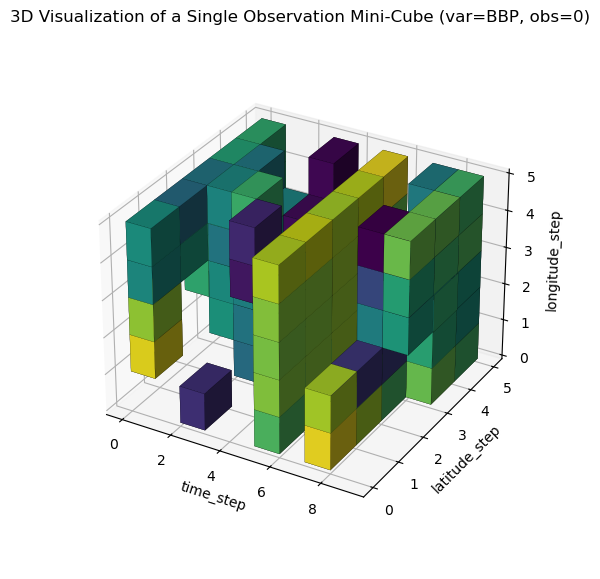

In [16]:
plot_obs(result, var='BBP', iobs=0)